In [1]:
import pandas as pd
import json

In [2]:
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [3]:
RESULT_PATH = '../logs/l1_surplus_fast.txt'

In [4]:
general_agg_functions = {
    'total_equations': 'mean',
    'runtime': 'mean',
    'equations_used': 'mean',
    'filtered_equations': 'mean',
    'false_positive_rate': 'mean',
    'num_signatures': 'mean',
    'success': 'sum',
    'failure': 'sum'
}

In [5]:
def load_results(path: str) -> pd.DataFrame:
    LEVEL_TO_NL = {1: 512, 2: 512, 3: 512, 4: 512}
    LEVEL_TO_BETA = {1: 23, 2: 23, 3: 46, 4: 70}
    
    results = []
    with open(path, 'r') as file:
        for line in file.readlines():
            try:
                results.append(json.loads(line))
            except json.JSONDecodeError:
                    pass
    results = [result | {'attack_no': i} for i, result in enumerate(results)]
    
    df = pd.DataFrame(results)
    first_columns = ['attack_no', 'm', 'threshold', 'failure']
    df = df.reindex(columns=first_columns + list(set(df.columns) - set(first_columns)))
    df = df[df['threshold'] > 0]
    df['false_positive_rate'] = (df['filtered_equations'] - df['total_equations']) / df['filtered_equations']
    df['f'] = LEVEL_TO_NL[df['nist_param_level'].max()] - df['m']
    df['percent'] = df['m'] / LEVEL_TO_NL[df['nist_param_level'].max()]
    df['beta'] = LEVEL_TO_BETA[df['nist_param_level'].max()]
    df['success'] = 1 - df['failure']
    df['surplus'] = df['notion_of_success'] - 512
    df = df.drop('notion_of_success', axis=1)

    
    return df

In [6]:
def load_results_per_attack_run(df_per_attack: pd.DataFrame) -> pd.DataFrame:
    if type(df_per_attack) is str:
        df_per_attack = load_results(df_per_attack)
    df_per_attack = df_per_attack.reset_index(drop=True).drop('attack_no', axis=1).drop('status', axis=1)
    
    agg_functions = general_agg_functions
    no_agg = list(set(df_per_attack.columns) - set(agg_functions.keys()))
    print(no_agg)
    df_per_attack_run = df_per_attack.groupby(no_agg).agg(agg_functions).reset_index().set_index(['m', 'surplus'])
    df_per_attack_run = df_per_attack_run.sort_index(ascending=[True, True])
    return df_per_attack_run
    

In [7]:
def load_results_per_attack_run_successful(df_per_attack_run: pd.DataFrame) -> pd.DataFrame:
    if type(df_per_attack_run) is str:
        df_per_attack_run = load_results_per_attack_run(df_per_attack_run)
    df_per_attack_run = df_per_attack_run.reset_index()
        
    df_per_attack_run = df_per_attack_run[
        (df_per_attack_run['success'] == 2) &
        (df_per_attack_run['failure'] <= 1)]
    # df_per_attack_run = df_per_attack_run[df_per_attack_run['threshold'] < df_per_attack_run['beta']]
    # df_per_attack_run = df_per_attack_run[df_per_attack_run['f'] <= 4]
    
    df_per_attack_run['threshold_percent'] = df_per_attack_run['threshold'] / df_per_attack_run['beta']
    # df_per_attack_run['actual_surplus_of_equations'] = df_per_attack_run['faulted_coeffs'] - 256
        
    return df_per_attack_run.set_index(['m', 'surplus'])

In [8]:
df = load_results(RESULT_PATH)
df

,attack_no,m,threshold,failure,total_equations,equations_used,filtered_equations,status,num_signatures,runtime,nist_param_level,timeout_limit,false_positive_rate,f,percent,beta,success,surplus
0,0,0,23,False,512,512.0,512,INTERRUPTED,1,1.800095,1,300,0.000000,512,0.000000,23,1,0
1,1,0,23,False,512,512.0,512,INTERRUPTED,1,2.962762,1,300,0.000000,512,0.000000,23,1,0
2,2,1,23,False,1022,1022.0,1023,INTERRUPTED,2,5.214655,1,300,0.000978,511,0.001953,23,1,0
3,3,1,23,False,1022,1022.0,1023,INTERRUPTED,2,5.052659,1,300,0.000978,511,0.001953,23,1,0
4,4,2,23,False,1020,1020.0,1020,INTERRUPTED,2,2.008694,1,300,0.000000,510,0.003906,23,1,0
5,5,2,23,False,1020,1020.0,1020,INTERRUPTED,2,2.338532,1,300,0.000000,510,0.003906,23,1,0
6,6,3,23,False,1018,1018.0,1018,INTERRUPTED,2,2.101116,1,300,0.000000,509,0.005859,23,1,0
7,7,3,23,False,1018,1018.0,1018,INTERRUPTED,2,2.279057,1,300,0.000000,509,0.005859,23,1,0
8,8,4,23,False,1016,1016.0,1018,INTERRUPTED,2,5.942305,1,300,0.001965,508,0.007812,23,1,0
9,9,4,23,False,1016,1016.0,1017,INTERRUPTED,2,5.496123,1,300,0.000983,508,0.007812,23,1,0


In [9]:
df_per_attack_run = load_results_per_attack_run(RESULT_PATH)
df_per_attack_run

['f', 'beta', 'm', 'threshold', 'surplus', 'percent', 'nist_param_level', 'timeout_limit']


,,f,beta,threshold,percent,nist_param_level,timeout_limit,total_equations,runtime,equations_used,filtered_equations,false_positive_rate,num_signatures,success,failure
m,surplus,,,,,,,,,,,,,,
0,0,512,23,23,0.000000,1,300,512.000000,2.381428,512.000000,512.000000,0.000000,1.000000,2,0
1,0,511,23,23,0.001953,1,300,1022.000000,5.133657,1022.000000,1023.000000,0.000978,2.000000,2,0
2,0,510,23,23,0.003906,1,300,1020.000000,2.173613,1020.000000,1020.000000,0.000000,2.000000,2,0
3,0,509,23,23,0.005859,1,300,1018.000000,2.190087,1018.000000,1018.000000,0.000000,2.000000,2,0
4,0,508,23,23,0.007812,1,300,1016.000000,5.719214,1016.000000,1017.500000,0.001474,2.000000,2,0
5,0,507,23,23,0.009766,1,300,1014.000000,6.308792,1014.000000,1016.000000,0.001968,2.000000,2,0
6,0,506,23,23,0.011719,1,300,1012.000000,5.063890,1012.000000,1013.500000,0.001480,2.000000,2,0
7,0,505,23,23,0.013672,1,300,1010.000000,3.794451,1010.000000,1011.000000,0.000988,2.000000,2,0
8,0,504,23,23,0.015625,1,300,1008.000000,5.545746,1008.000000,1010.000000,0.001979,2.000000,2,0


In [10]:
df_per_attack_run_successful = load_results_per_attack_run_successful(RESULT_PATH)
df_per_attack_run_successful

['f', 'beta', 'm', 'threshold', 'surplus', 'percent', 'nist_param_level', 'timeout_limit']


,,f,beta,threshold,percent,nist_param_level,timeout_limit,total_equations,runtime,equations_used,filtered_equations,false_positive_rate,num_signatures,success,failure,threshold_percent
m,surplus,,,,,,,,,,,,,,,
0,0,512,23,23,0.000000,1,300,512.000000,2.381428,512.000000,512.000000,0.000000,1.0,2,0,1.0
1,0,511,23,23,0.001953,1,300,1022.000000,5.133657,1022.000000,1023.000000,0.000978,2.0,2,0,1.0
2,0,510,23,23,0.003906,1,300,1020.000000,2.173613,1020.000000,1020.000000,0.000000,2.0,2,0,1.0
3,0,509,23,23,0.005859,1,300,1018.000000,2.190087,1018.000000,1018.000000,0.000000,2.0,2,0,1.0
4,0,508,23,23,0.007812,1,300,1016.000000,5.719214,1016.000000,1017.500000,0.001474,2.0,2,0,1.0
5,0,507,23,23,0.009766,1,300,1014.000000,6.308792,1014.000000,1016.000000,0.001968,2.0,2,0,1.0
6,0,506,23,23,0.011719,1,300,1012.000000,5.063890,1012.000000,1013.500000,0.001480,2.0,2,0,1.0
7,0,505,23,23,0.013672,1,300,1010.000000,3.794451,1010.000000,1011.000000,0.000988,2.0,2,0,1.0
8,0,504,23,23,0.015625,1,300,1008.000000,5.545746,1008.000000,1010.000000,0.001979,2.0,2,0,1.0


In [11]:
l2 = load_results_per_attack_run_successful('../logs/l1_surplus_fast.txt').reset_index().set_index('m').add_prefix('l1_')
l3 = load_results_per_attack_run_successful('../logs/l2_surplus_fast.txt').reset_index().set_index('m').add_prefix('l2_')
l5 = load_results_per_attack_run_successful('../logs/l3_surplus_fast_final.txt').reset_index().set_index('m').add_prefix('l3_')
l99 = load_results_per_attack_run_successful('../logs/l4_surplus_fast.txt').reset_index().set_index('m').add_prefix('l4_')
all_lvls = l2.join([l3, l5, l99], how='outer').sort_index()
all_lvls

['f', 'beta', 'm', 'threshold', 'surplus', 'percent', 'nist_param_level', 'timeout_limit']
['f', 'beta', 'm', 'threshold', 'surplus', 'percent', 'nist_param_level', 'timeout_limit']
['f', 'beta', 'm', 'threshold', 'surplus', 'percent', 'nist_param_level', 'timeout_limit']
['f', 'beta', 'm', 'threshold', 'surplus', 'percent', 'nist_param_level', 'timeout_limit']


,l1_surplus,l1_f,l1_beta,l1_threshold,l1_percent,l1_nist_param_level,l1_timeout_limit,l1_total_equations,l1_runtime,l1_equations_used,l1_filtered_equations,l1_false_positive_rate,l1_num_signatures,l1_success,l1_failure,l1_threshold_percent,l2_surplus,l2_f,l2_beta,l2_threshold,l2_percent,l2_nist_param_level,l2_timeout_limit,l2_total_equations,l2_runtime,l2_equations_used,l2_filtered_equations,l2_false_positive_rate,l2_num_signatures,l2_success,l2_failure,l2_threshold_percent,l3_surplus,l3_f,l3_beta,l3_threshold,l3_percent,l3_nist_param_level,l3_timeout_limit,l3_total_equations,l3_runtime,l3_equations_used,l3_filtered_equations,l3_false_positive_rate,l3_num_signatures,l3_success,l3_failure,l3_threshold_percent,l4_surplus,l4_f,l4_beta,l4_threshold,l4_percent,l4_nist_param_level,l4_timeout_limit,l4_total_equations,l4_runtime,l4_equations_used,l4_filtered_equations,l4_false_positive_rate,l4_num_signatures,l4_success,l4_failure,l4_threshold_percent
m,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,512,23,23,0.000000,1,300,512.000000,2.381428,512.000000,512.000000,0.000000,1.0,2,0,1.0,0.0,512.0,23.0,23.0,0.000000,2.0,300.0,512.000000,2.734746,512.000000,512.000000,0.000000,1.000000,2.0,0.0,1.0,0.0,512.0,46.0,60.0,0.000000,3.0,300.0,512.000000,2.903249,512.000000,512.000000,0.000000,1.0,2.0,0.0,1.304348,0.0,512.0,70.0,70.0,0.000000,4.0,300.0,512.0,3.163611,512.0,512.0,0.000000,1.0,2.0,0.0,1.0
1,0,511,23,23,0.001953,1,300,1022.000000,5.133657,1022.000000,1023.000000,0.000978,2.0,2,0,1.0,0.0,511.0,23.0,23.0,0.001953,2.0,300.0,1022.000000,2.032954,1022.000000,1022.000000,0.000000,2.000000,2.0,0.0,1.0,0.0,511.0,46.0,60.0,0.001953,3.0,300.0,1022.000000,2.846450,1022.000000,1022.000000,0.000000,2.0,2.0,0.0,1.304348,0.0,511.0,70.0,70.0,0.001953,4.0,300.0,1022.0,2.789171,1022.0,1022.0,0.000000,2.0,2.0,0.0,1.0
2,0,510,23,23,0.003906,1,300,1020.000000,2.173613,1020.000000,1020.000000,0.000000,2.0,2,0,1.0,0.0,510.0,23.0,23.0,0.003906,2.0,300.0,1020.000000,2.096437,1020.000000,1020.000000,0.000000,2.000000,2.0,0.0,1.0,0.0,510.0,46.0,60.0,0.003906,3.0,300.0,1020.000000,4.877807,1020.000000,1020.500000,0.000490,2.0,2.0,0.0,1.304348,0.0,510.0,70.0,70.0,0.003906,4.0,300.0,1020.0,7.035632,1020.0,1021.5,0.001468,2.0,2.0,0.0,1.0
3,0,509,23,23,0.005859,1,300,1018.000000,2.190087,1018.000000,1018.000000,0.000000,2.0,2,0,1.0,0.0,509.0,23.0,23.0,0.005859,2.0,300.0,1018.000000,5.425648,1018.000000,1020.000000,0.001961,2.000000,2.0,0.0,1.0,0.0,509.0,46.0,60.0,0.005859,3.0,300.0,1018.000000,2.443008,1018.000000,1018.000000,0.000000,2.0,2.0,0.0,1.304348,0.0,509.0,70.0,70.0,0.005859,4.0,300.0,1018.0,7.159647,1018.0,1020.5,0.002448,2.0,2.0,0.0,1.0
4,0,508,23,23,0.007812,1,300,1016.000000,5.719214,1016.000000,1017.500000,0.001474,2.0,2,0,1.0,0.0,508.0,23.0,23.0,0.007812,2.0,300.0,1016.000000,5.053544,1016.000000,1018.500000,0.002454,2.000000,2.0,0.0,1.0,0.0,508.0,46.0,60.0,0.007812,3.0,300.0,1016.000000,4.322489,1016.000000,1017.000000,0.000982,2.0,2.0,0.0,1.304348,0.0,508.0,70.0,70.0,0.007812,4.0,300.0,1016.0,7.076982,1016.0,1018.0,0.001964,2.0,2.0,0.0,1.0
5,0,507,23,23,0.009766,1,300,1014.000000,6.308792,1014.000000,1016.000000,0.001968,2.0,2,0,1.0,0.0,507.0,23.0,23.0,0.009766,2.0,300.0,1014.000000,2.265844,1014.000000,1014.000000,0.000000,2.000000,2.0,0.0,1.0,0.0,507.0,46.0,60.0,0.009766,3.0,300.0,1014.000000,6.932045,1014.000000,1016.500000,0.002459,2.0,2.0,0.0,1.304348,0.0,507.0,70.0,70.0,0.009766,4.0,300.0,1014.0,6.545321,1014.0,1015.0,0.000985,2.0,2.0,0.0,1.0
6,0,506,23,23,0.011719,1,300,1012.000000,5.063890,1012.000000,1013.500000,0.001480,2.0,2,0,1.0,0.0,506.0,23.0,23.0,0.011719,2.0,300.0,1012.000000,5.488516,1012.000000,1014.000000,0.001971,2.000000,2.0,0.0,1.0,0.0,506.0,46.0,60.0,0.011719,3.0,300.0,1012.000000,6.316350,1012.000000,1014.500000,0.002462,2.0,2.0,0.0,1.304348,0.0,506.0,70.0,70.0,0.011719,4.0,300.0,1012.0,7.214039,1012.0,1014.0,0.001972,2.0,2.0,0.0,1.0
7,0,505,23,23,0.013672,1,300,1010.000000,3.794451,1010.000000,1011.000

<AxesSubplot:xlabel='no. of iterations before fault occurs (m)', ylabel='surplus of equations'>

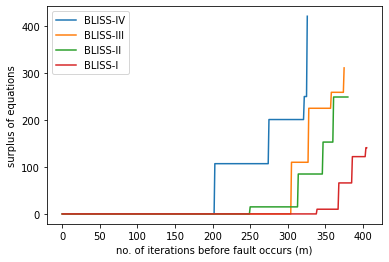

In [12]:
ax = all_lvls[['l4_surplus', 'l3_surplus', 'l2_surplus', 'l1_surplus']].rename(columns={
        'l4_surplus': 'BLISS-IV',
        'l3_surplus': 'BLISS-III',
        'l2_surplus': 'BLISS-II',
        'l1_surplus': 'BLISS-I',
        }
                                                         ).plot()
ax.set_xlabel('no. of iterations before fault occurs (m)')
ax.set_ylabel('surplus of equations')
fig = ax.get_figure()
fig.savefig(f'bliss_surplus.pdf', format="pdf", bbox_inches='tight', transparent=True)
ax

<AxesSubplot:xlabel='no. of iterations before fault occurs (m)', ylabel='average signature count'>

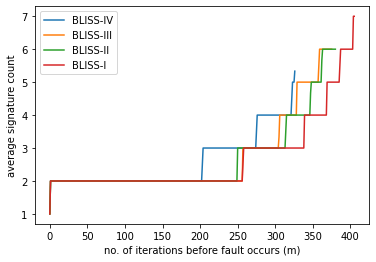

In [13]:
ax = all_lvls[['l4_num_signatures', 'l3_num_signatures', 'l2_num_signatures', 'l1_num_signatures']].rename(columns={
        'l4_num_signatures': 'BLISS-IV',
        'l3_num_signatures': 'BLISS-III',
        'l2_num_signatures': 'BLISS-II',
        'l1_num_signatures': 'BLISS-I',
        }
                                                         ).plot()
ax.set_xlabel('no. of iterations before fault occurs (m)')
ax.set_ylabel('average signature count')
fig = ax.get_figure()
fig.savefig(f'bliss_surplus_sigcount.pdf', format="pdf", bbox_inches='tight', transparent=True)
ax

<AxesSubplot:xlabel='no. of iterations before fault occurs (m)', ylabel='effective surplus of equations'>

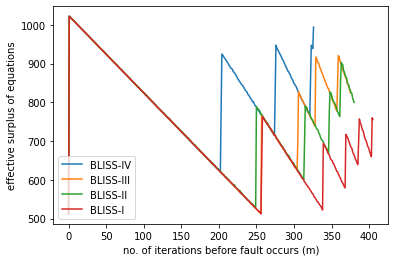

In [14]:
ax = all_lvls[['l4_total_equations', 'l3_total_equations', 'l2_total_equations', 'l1_total_equations']].rename(columns={
        'l4_total_equations': 'BLISS-IV',
        'l3_total_equations': 'BLISS-III',
        'l2_total_equations': 'BLISS-II',
        'l1_total_equations': 'BLISS-I',
        }
                                                         ).plot()
ax.set_xlabel('no. of iterations before fault occurs (m)')
ax.set_ylabel('effective surplus of equations')
fig = ax.get_figure()
fig.savefig(f'bliss_surplus_effective.pdf', format="pdf", bbox_inches='tight', transparent=True)
ax